# Get Dataset

In [ ]:
# upload kaggle key to get dataset
from google.colab import files
files.upload()

In [2]:
# create directory for dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download dataset
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

In [4]:
# show file list
!ls -d $PWD/*

/content/drive			 /content/kaggle.json
/content/example_submission.csv  /content/sample_data
/content/fer2013.tar.gz		 /content/test.csv.zip
/content/icml_face_data.csv.zip  /content/train.csv.zip


In [ ]:
# unzip files and delete zip files
!unzip \*.zip && rm *.zip

In [6]:
# show file list after unzipping
!ls -d $PWD/*

/content/drive			 /content/kaggle.json
/content/example_submission.csv  /content/sample_data
/content/fer2013.tar.gz		 /content/test.csv
/content/icml_face_data.csv	 /content/train.csv


In [ ]:
# install vggface model
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

In [ ]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import collections
import cv2
import os
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import  Flatten, Dropout, Dense
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras import regularizers
from keras import applications as keras_applications
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [9]:
# get data path
data_path = '/content/icml_face_data.csv'

In [10]:
# read input data into dataframe
data = pd.read_csv(data_path)
data.head(5)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# Exploratory Data Analysis

In [11]:
# show data columns
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

In [12]:
#show sample pixel
np.array(data[' pixels'][0])

array('70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58

In [13]:
# show length of data
print('The number of data points : {}'.format(len(data))) 

The number of data points : 35887


In [14]:
# show data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [15]:
# check for null values
print('Number of null values for columns in  data')
data.isnull().sum()

Number of null values for columns in  data


emotion    0
 Usage     0
 pixels    0
dtype: int64

In [16]:
# show  unique labels
print('the unique classes of emotions are : {}'.format(np.sort(data['emotion'].unique())))

the unique classes of emotions are : [0 1 2 3 4 5 6]


In [17]:
# dict that maps labels to classes
class_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
# class_dict

In [18]:
# show  labels count
emotion_count = pd.DataFrame(data['emotion'].value_counts()).rename(index=class_dict, columns= {'emotion':'Num_values'})
emotion_count

,Num_values
Happy,8989
Neutral,6198
Sad,6077
Fear,5121
Angry,4953
Surprise,4002
Disgust,547


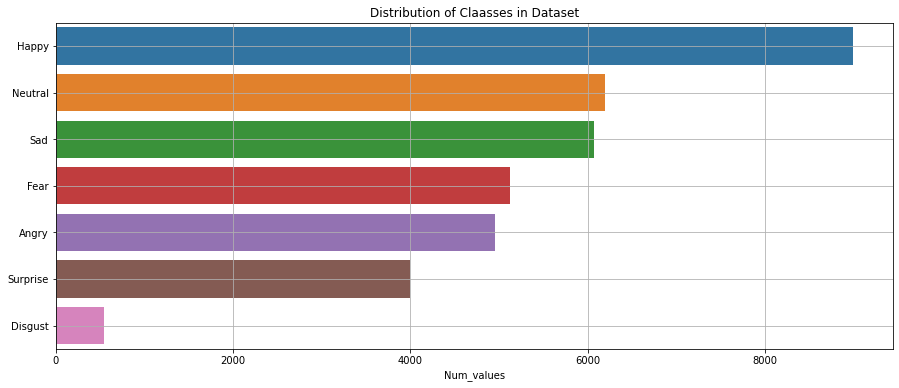

In [19]:
# plot count of labels
plt.figure(figsize= (15,6))
sns.barplot(x= emotion_count['Num_values'], y= emotion_count.index.to_list())
plt.title('Distribution of Claasses in Dataset')
plt.grid(True)
plt.show()

In [20]:
# display pieplot of label distribution.
pie_plot = go.Pie(labels= emotion_count.index.to_list(), values=emotion_count.values.flatten(), 
                  hole=0.3, text= emotion_count.index.to_list(),textposition= 'auto')
fig = go.Figure(data=[pie_plot])
fig.update_layout(title_text='Pie Plot of Emotion Distribution')
fig.show()

### The plots show imbalance in the dataset with the disgust class having smaller number of samples compared to other classes. I would oversample the dataset after splitting to increase sample for such class.

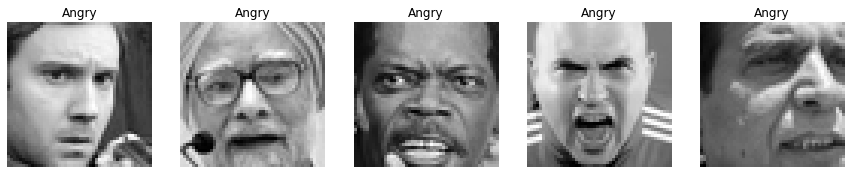

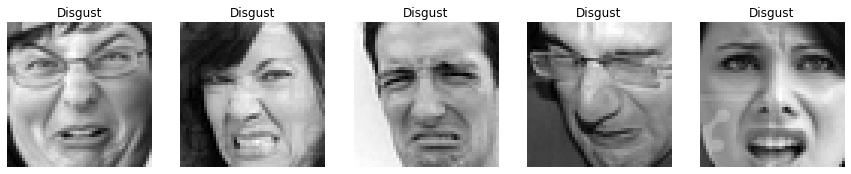

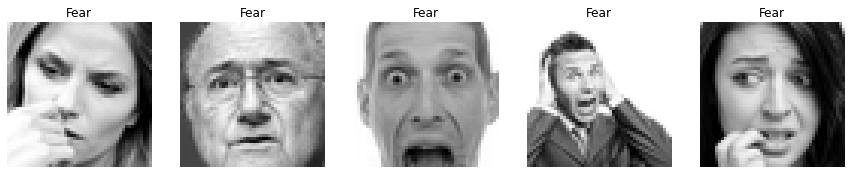

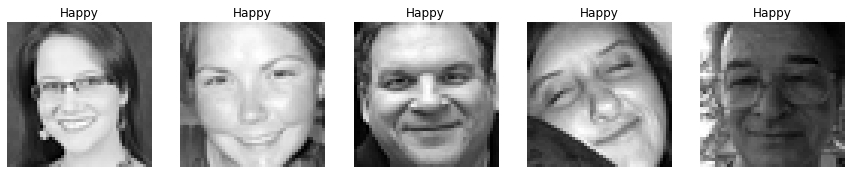

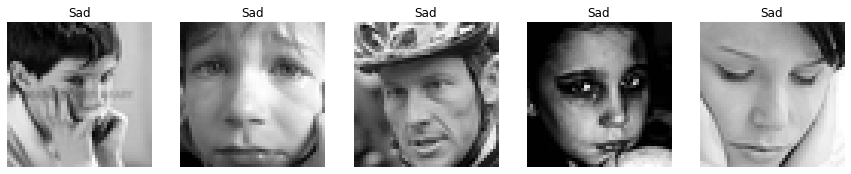

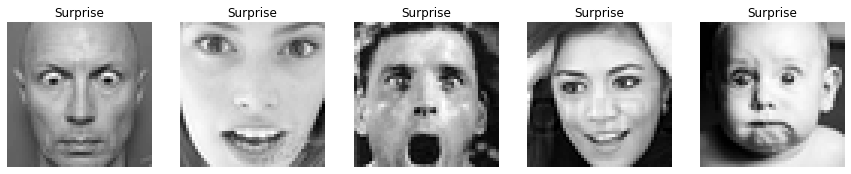

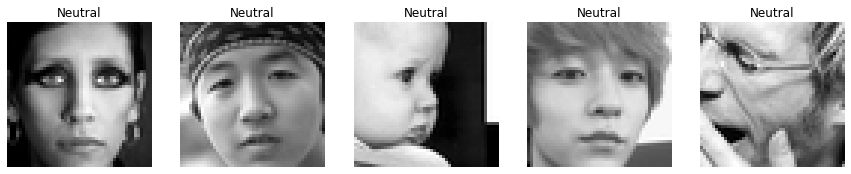

In [21]:
# plot sample images
for i, label in enumerate(list(class_dict.keys())):
  class_series = data[data['emotion']== label][' pixels']
  values = class_series.values
  fig = plt.figure(figsize = (15,6))
  for j in range(5):
    img_pixel = np.fromstring(values[j], dtype= int, sep=' ' )  
    img = img_pixel.reshape((48,48)) 
    fig.add_subplot(1,5, j+1)
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(class_dict[label]) 

In [22]:
# show  unique values in usage column
data[' Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

# Data Preprocessing

In [23]:
# get train set
train_data = data[data[' Usage']=='Training']
len(train_data)

28709

In [24]:
# get validation set
val_data = data[data[' Usage']=='PrivateTest']
len(val_data)

3589

In [25]:
# get test set
test_data = data[data[' Usage']=='PublicTest']
len(test_data)

3589

#### Oversampling to check data imbalance

In [26]:
# oversample train data
oversampler = RandomOverSampler(sampling_strategy='auto', random_state= 0)
train_data, train_labels = oversampler.fit_resample(train_data[' pixels'].values.reshape(-1,1), train_data['emotion'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [27]:
# change train data format to series
train_data = pd.Series(train_data.flatten())
train_data[:3]

0    70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1    151 150 147 155 148 133 111 140 170 174 182 15...
2    231 212 156 164 174 138 161 173 182 200 106 38...
dtype: object

In [28]:
# show label count after oversampling
collections.Counter(train_labels)

Counter({0: 7215, 1: 7215, 2: 7215, 3: 7215, 4: 7215, 5: 7215, 6: 7215})

In [29]:
# show length of train data after oversmpling
len(train_data), len(train_labels)

(50505, 50505)

In [30]:
# get image pixels as array
def preprocess_pixels(pixel_series):
  images = []
  for i in range(len(pixel_series)):
    img_array = np.fromstring(pixel_series[i], dtype= int, sep=' ')
    img_array = img_array.reshape(48, 48, 1)
    images.append(img_array)
  return np.array(images)

In [31]:
# get train data as array
x_train = preprocess_pixels(train_data)
y_train = train_labels

In [32]:
# get val data as array
val_data.reset_index(inplace=True)
x_val = preprocess_pixels(val_data[' pixels'])
y_val = val_data['emotion'].values

In [33]:
# get test data as array
test_data.reset_index(inplace=True)
x_test = preprocess_pixels(test_data[' pixels'])
y_test = test_data['emotion'].values

In [34]:
# normalize input features
# x_train = x_train/255
# x_val = x_val/255
# x_test = x_test/255

In [35]:
# show shapes of input features
x_train.shape, x_val.shape, x_test.shape

((50505, 48, 48, 1), (3589, 48, 48, 1), (3589, 48, 48, 1))

In [36]:
# one-hot-encode input labels 
y_train = to_categorical(y_train, num_classes=7)
y_val =  to_categorical(y_val, num_classes=7)
y_test =  to_categorical(y_test, num_classes=7)

In [37]:
# label smoothening method
from copy import deepcopy as copy

def smooth_labels(y, smooth_factor):
  'Smoothen the labels by a factor to check overfitting'
  assert len(y.shape) == 2, 'input should be a batch of one-hot-encoded data'
  y2 = copy(y)
  if 0 <= smooth_factor <= 1:
    y2 *= 1 - smooth_factor
    y2 += smooth_factor / y.shape[1]
  else:
    raise Exception(
        'Invalid label smoothing factor: ' + str(smooth_factor))
  return y2

In [38]:
# data generator
class ImageDataSequence(Sequence):
  '''
      yields sequence of data
      features -- list of features
      labels -- list of labels
      target_channels {int} -- 1 (gray) or 3(RGB)
  '''
  def __init__(self, features, labels, batch_size= 16, target_dim= (224,224), n_classes = 7, shuffle = True,
              smooth = 0.0, target_channels=3):
    'Initialize variables'
    assert len(features)==len(labels), 'number of feature and labels must be consistent'
    self.features = features
    self.labels = labels
    self.batch_size = batch_size
    self.target_dim = target_dim
    self.target_channels = target_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.smooth = smooth
    self.sample_count = len(labels)
    self.indexes = np.arange(self.sample_count)
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return (self.sample_count // self.batch_size)

  def __gray2RGB__(self,x):
    'converts grayscale inputs to RGB'
    if len(x.shape) == 2:
      return np.stack((x,x,x),-1)
    else:
      assert len(x.shape)==3
      if len(x[0,0,:]) == 1:
        return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
      else:
        assert len(x[0,0,:])==self.target_channels
    return x

  def __getitem__(self, idx):

    'Generates one batch of data'

    # Generate indexes of the batch
    indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]

    # create empty array of target shapes for features and labels
    X = np.empty((self.batch_size, *self.target_dim, self.target_channels))
    Y = np.empty((self.batch_size, self.n_classes))

    
    for i,ind in enumerate(indexes):
      # get features batch
      x = self.features[ind]
      x = x.astype('float32')
  
      # resize image to the target size 
      x = cv2.resize(x,self.target_dim,interpolation=cv2.INTER_CUBIC)

      # converts grayscale image  to RGB
      x = self.__gray2RGB__(x)
      X[i] = utils.preprocess_input(x, version=2)

      # get labels batch
      y = self.labels[ind]

      # convert int labels to categorical
      if isinstance(y,int):
        Y[i]=to_categorical(y,7)
      else:
        assert len(y)==self.n_classes, 'length of labels should be consistent'
        Y[i]=y
    X = np.array(X)
    Y = np.array(Y)
    if self.smooth > 0.0:
      smooth_labels(Y, self.smooth)
    return X,Y
      
  def on_epoch_end(self):
    'Updates indexes after each epoch'
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

In [39]:
# initialize generators for data sets
train_sequence = ImageDataSequence(x_train,y_train,batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.07)
val_sequence   = ImageDataSequence(x_val,  y_val,  batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)
test_sequence  = ImageDataSequence(x_test, y_test, batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)

# Emotion Classifier Model Building

In [40]:
# initialize VGGFace model
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))
vggface.trainable = False
# vggface.summary()

94699520/94694792 [==============================] - 2s 0us/step


In [41]:
# build model
emotion_model = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(2048, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(7, activation='softmax')])


In [42]:
# compile model

emotion_model.compile(optimizer = keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 7

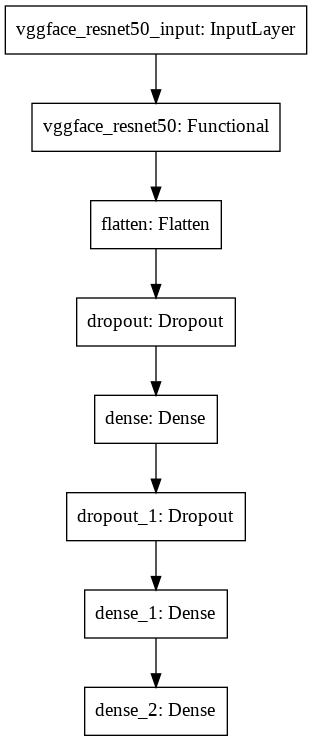

In [43]:
# show model summary
emotion_model.summary()

# display model structure
plot_model(emotion_model, 'emotion_model.png')

# Model Training

In [44]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience= 2, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_acc', patience = 4, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('emotion_model.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

In [45]:
# train model
history = emotion_model.fit(train_sequence,
                           validation_data = val_sequence,
                           epochs = 7, callbacks= [reduceLR, early_stopping, checkpoint])

Epoch 1/7
789/789 [==============================] - 360s 414ms/step - loss: 1.6504 - acc: 0.4564 - val_loss: 1.0617 - val_acc: 0.6099

Epoch 00001: val_loss improved from inf to 1.06166, saving model to emotion_model.weights.hdf5
Epoch 2/7
789/789 [==============================] - 326s 413ms/step - loss: 0.9068 - acc: 0.6687 - val_loss: 0.9560 - val_acc: 0.6496

Epoch 00002: val_loss improved from 1.06166 to 0.95601, saving model to emotion_model.weights.hdf5
Epoch 3/7
789/789 [==============================] - 326s 413ms/step - loss: 0.7305 - acc: 0.7351 - val_loss: 0.9279 - val_acc: 0.6596

Epoch 00003: val_loss improved from 0.95601 to 0.92790, saving model to emotion_model.weights.hdf5
Epoch 4/7
789/789 [==============================] - 326s 413ms/step - loss: 0.6076 - acc: 0.7847 - val_loss: 0.9303 - val_acc: 0.6780

Epoch 00004: val_loss did not improve from 0.92790
Epoch 5/7
789/789 [==============================] - 326s 413ms/step - loss: 0.5018 - acc: 0.8247 - val_loss: 0.

In [46]:
# read training history into dataframe
history_df = pd.DataFrame(history.history)

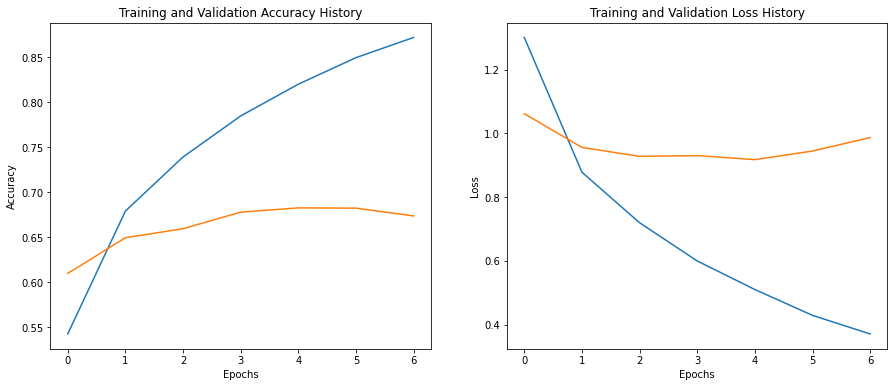

In [47]:
# display training and validation history

# display history of accurracy
plt.figure(figsize= (15,6))
plt.subplot(1,2,1)
plt.plot(history_df['acc'])
plt.plot(history_df['val_acc'])
# history_df[['acc', 'val_acc']]
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')

# display history of accurracy
plt.subplot(1,2,2)
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
# history_df[['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')

plt.show()

In [48]:
# # load best weights to model
# emotion_model.load_weights('emotion_model.weights.hdf5')

In [54]:
# # save model 
# emotion_model.save('emotion_model.h5')

# MODEL TESTING

In [50]:
# evaluate model on test set
emotion_model.evaluate(test_sequence) 

56/56 [==============================] - 22s 386ms/step - loss: 0.9828 - acc: 0.6632


[0.9828375577926636, 0.6632254719734192]

In [51]:
# load sample image for testing
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size = (224,224))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  # test_img /= 255
  return test_img

Test model with custom images

In [52]:
path = ''   # path to image folder

In [53]:
def test_model(path):
  'Takes a folder path of images and displays images with predicted classes'
  
  file_list = os.listdir(path)      # get list of files in path
  for file_name in file_list:        # iterate through all file_names in path
    img_path = path + file_name       # get full  path
    try:
      test_image = loadImage(img_path)        # get image pixels
      test_pred = emotion_model.predict(test_image)       # predict class of image
      img = image.load_img(img_path)        # load image    
      plt.imshow(img)    # display image
      plt.xlabel(class_dict[np.argmax(test_pred)])      # show predicted class of image
      plt.axis(False)       # remove axis
      plt.show()
      print(class_dict[np.argmax(test_pred)]) 
    except: 
      pass

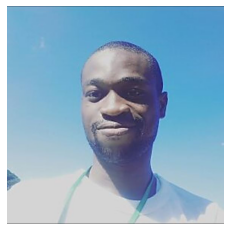

Sad


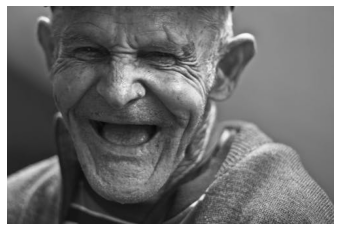

Angry


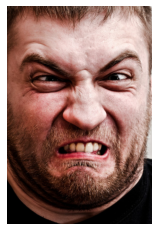

Angry


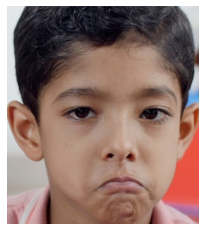

Sad


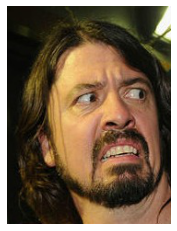

Angry


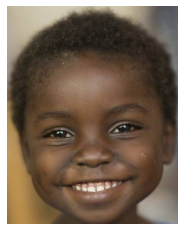

Happy


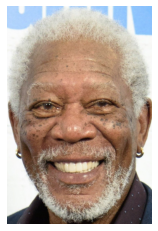

Happy


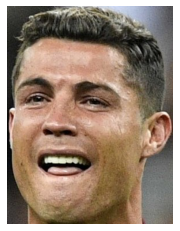

Happy


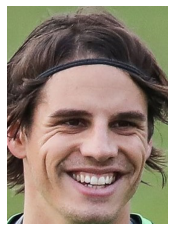

Happy


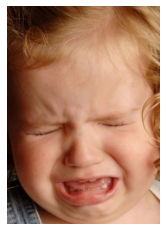

Sad


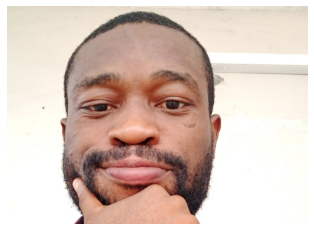

Neutral


In [55]:
test_model(path)